In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

from pylab import rcParams

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Models
from sklearn import dummy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Over-sampling 
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Under-sampling
from imblearn.under_sampling import RandomUnderSampler

#Pipeline
from imblearn.pipeline import Pipeline 

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 6, 4
warnings.filterwarnings('ignore')
sns.set(style= 'whitegrid')

# C) Elaboration et choix du meilleur modèle 
    - equilibrage des classes
    - comparaison des modèles 

In [3]:
# récupération du fichier après Analyse Exploratoire et Feature Engineering

df = pd.read_csv('df_final.csv', sep=',')

In [4]:
# fonctions communes

def generate_crosstab():
    return(pd.crosstab(pd.Series(Y_test_pred, name = 'Predicted'), pd.Series(Y_test['TARGET'], name = 'Actual')))

def generate_auc_roc_curve(model, X_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr, tpr, label = 'AUC ROC Curve with Area under the curve = ' + str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [5]:
# Préparation du jeu d'entraînement et du jeu de test

X = df.loc[:, df.columns != 'TARGET']
Y = df.loc[:, df.columns == 'TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state=50)

Y_train['TARGET'].value_counts()

0.0    197835
1.0     17419
Name: TARGET, dtype: int64

#### Equilibrage des classes

On a observé durant l'Analyse Exploratoire un déséquilibre clair du nombre de clients dont la demande de prêt a été acceptée (1 - 8.07%) et ceux à qui elle a été refusée (0 - 91.93%). 

Afin de travailler sur un jeu de données équilibrés, nous allons utiliser plusieurs techniques de rééquilibrage des classes:

    - Données brutes 
    - Undersampling the biggest class => RandomUnderSampler()
                Inconvénient => perte possible d'importantes informations concernant la classe majoritaire
    - Oversampling the smallest class => SMOTE - sklearn
    - Pondération des classes => Class_weight = 'balanced'
                Permet de donner automatiquement plus de poids à la classe minoritaire

In [6]:
# Pondération de chaque classe pour: Class_weight = 'balanced'

unique_classes = list(df['TARGET'].unique())
out_dict = {}
for classes in unique_classes: 
    out_dict[classes] = df.shape[0]/((df.loc[df['TARGET'] == classes].shape[0])*len(unique_classes))
out_dict    

{1.0: 6.1934944612286005, 0.0: 0.5439097643288218}

In [7]:
cw = class_weight.compute_class_weight(class_weight ='balanced', classes= np.unique(Y_train), y=Y_train['TARGET'])
cw

array([0.54402406, 6.1787129 ])

## 1° Test des différents modèles

In [8]:
# création d'un tableau pour renseigner les différents scores
index = []
scores = {'Balance_method': [], 'AUC': [], 'AUC_test': [], 'Time': []}

In [9]:
from sklearn.model_selection import GridSearchCV as GS

### a)   Dummy Classifier- Baseline 

####  Données Brutes

In [10]:
param_grid = {'strategy': ['most_frequent', 'constant', 'prior', 'stratified', 'uniform', 'constant']}
grid = GS(dummy.DummyClassifier(), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.5000756086550517
meilleur paramètre :  {'strategy': 'stratified'}


In [11]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,23534,2051
1.0,2143,165


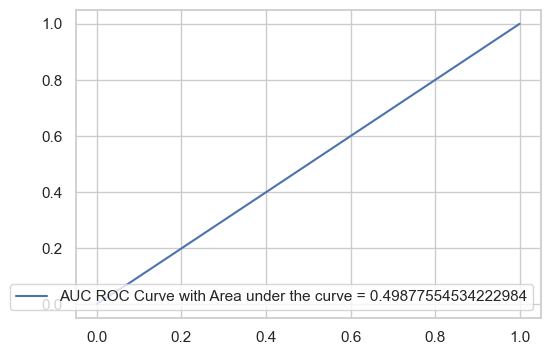

In [12]:
generate_auc_roc_curve(model, X_test)

In [13]:
index += ['DummyClassifier']
scores['Balance_method'].append('None')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2)  

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0


### b)  Logistic Regression

#### 1° LR - Données Brutes

In [14]:
param_grid = {'penalty' :['elasticnet', 'none']}   
grid = GS(LogisticRegression(), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.5506221407992109
meilleur paramètre :  {'penalty': 'none'}


In [15]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25676,2216
1.0,1,0


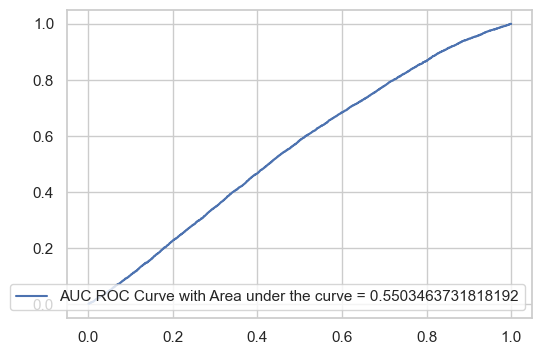

In [16]:
generate_auc_roc_curve(model, X_test)

In [17]:
index += ['LogisticRegression']
scores['Balance_method'].append('None')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0


#### 2° LR - Undersampling

In [18]:
model = Pipeline(steps = [['under', RandomUnderSampler()], ['classifier', LogisticRegression(random_state=50)]])

param_grid = {'classifier__penalty' :['elasticnet', 'none']}  
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.5812585682567806
meilleur paramètre :  {'classifier__penalty': 'none'}


In [19]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,23023,1974
1.0,2654,242


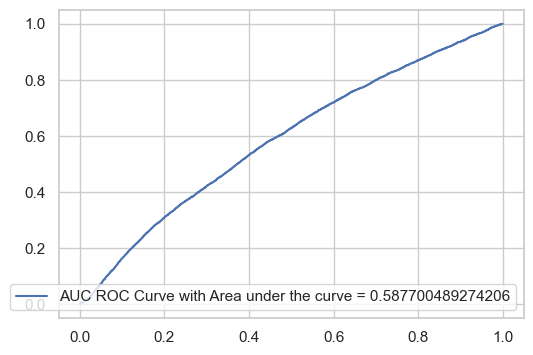

In [20]:
generate_auc_roc_curve(model, X_test)

In [21]:
index += ['LogisticRegression']
scores['Balance_method'].append('Undersampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0


#### 3° LR - Oversampling

In [22]:
model = Pipeline(steps = [['smote', SMOTE(random_state=11)], ['classifier', LogisticRegression(random_state=50)]])

param_grid = {'classifier__penalty' :['elasticnet', 'none']}  
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.5876051302807761
meilleur paramètre :  {'classifier__penalty': 'none'}


In [23]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,12120,1032
1.0,13557,1184


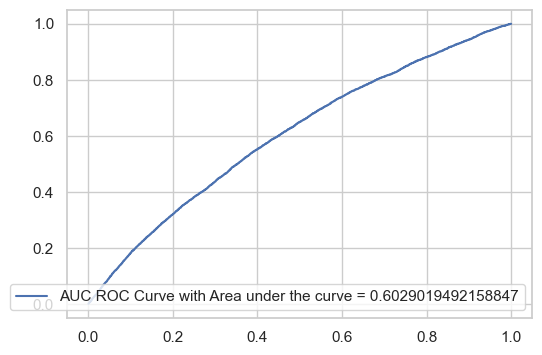

In [24]:
generate_auc_roc_curve(model, X_test)

In [25]:
index += ['LogisticRegression']
scores['Balance_method'].append('Oversampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0


#### 4° LR - Class_weight = Balanced

In [26]:
param_grid = {'penalty' :['elasticnet', 'none']}   
grid = GS(LogisticRegression(class_weight = 'balanced'), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.594089110967881
meilleur paramètre :  {'penalty': 'none'}


In [27]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)
generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,19722,1698
1.0,5955,518


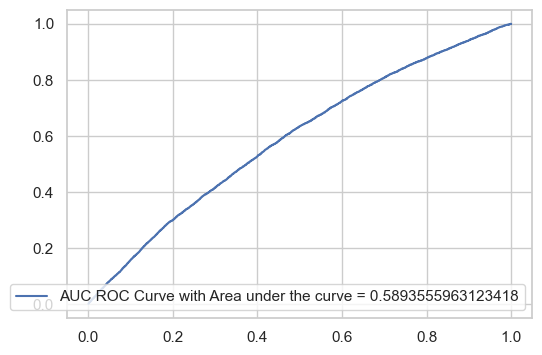

In [28]:
generate_auc_roc_curve(model, X_test)

In [29]:
index += ['LogisticRegression']
scores['Balance_method'].append('Class_weight=balanced')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0


### c)  RandomForestClassifier

#### 1° RFC - Données Brutes

In [31]:
param_grid = { "n_estimators" : [100], # number of trees in the forest
                "max_depth" : [4, 6] }  # maximum depth of the tree

grid = GS(RandomForestClassifier(), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7332118335779148
meilleur paramètre :  {'max_depth': 6, 'n_estimators': 100}


In [32]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25677,2216


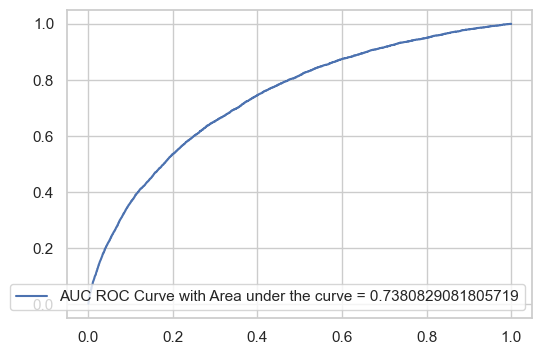

In [33]:
generate_auc_roc_curve(model, X_test)

In [34]:
index += ['RandomForest']
scores['Balance_method'].append('None')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0


#### 2° RFC - Undersampling

In [35]:
model = Pipeline(steps = [['under', RandomUnderSampler()], ['classifier', RandomForestClassifier(random_state=50)]])

param_grid = { 'classifier__n_estimators' : [100], 'classifier__max_depth' : [4, 6] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7309923994108682
meilleur paramètre :  {'classifier__max_depth': 6, 'classifier__n_estimators': 100}


In [36]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,16361,1429
1.0,9316,787


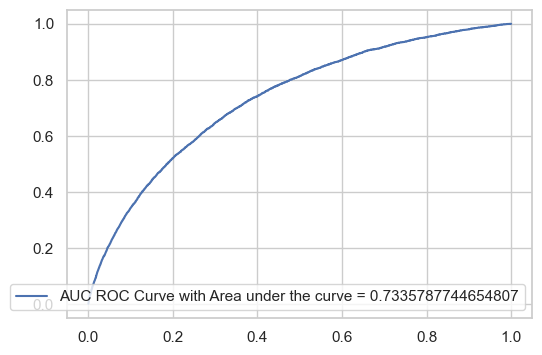

In [37]:
generate_auc_roc_curve(model, X_test)

In [38]:
index += ['RandomForest']
scores['Balance_method'].append('Undersampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0


#### 3° RFC - Oversampling

In [39]:
model = Pipeline(steps = [['smote', SMOTE(random_state=11)], ['classifier', RandomForestClassifier(random_state=50)]])

# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations RandomForest précédentes
param_grid = { 'classifier__n_estimators' : [100], 'classifier__max_depth' : [6] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.6678453535643236
meilleur paramètre :  {'classifier__max_depth': 6, 'classifier__n_estimators': 100}


In [40]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,23661,2048
1.0,2016,168


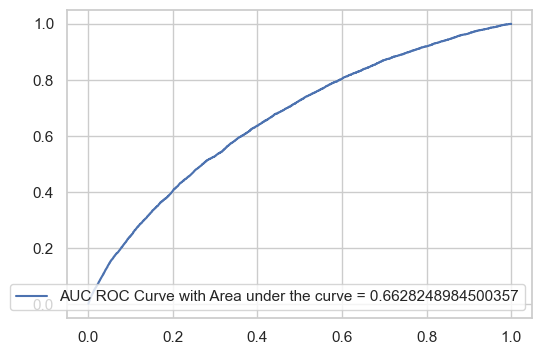

In [41]:
generate_auc_roc_curve(model, X_test)

In [42]:
index += ['RandomForest']
scores['Balance_method'].append('Oversampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0


#### 4° RFC - Class_weight = Balanced

In [43]:
# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations RandomForest précédentes
param_grid = { "n_estimators" : [100], "max_depth" : [6]}  
                
grid = GS(RandomForestClassifier(class_weight = 'balanced'), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7318321197430622
meilleur paramètre :  {'max_depth': 6, 'n_estimators': 100}


In [44]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,17067,1472
1.0,8610,744


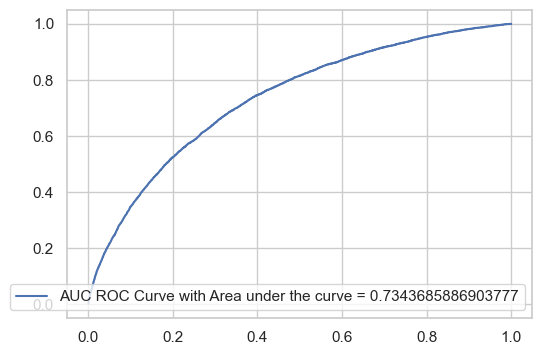

In [45]:
generate_auc_roc_curve(model, X_test)

In [46]:
index += ['RandomForest']
scores['Balance_method'].append('Class_weight=balanced')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0


### d) XGboost Classifier

#### 1° XGB - Données Brutes

In [47]:
param_grid = { "n_estimators" : [100], # number of trees in the forest
                "max_depth" : [3, 5] }  # maximum depth of the tree

grid = GS(XGBClassifier(objective='binary:logistic', eval_metric = 'auc'), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7750796626065922
meilleur paramètre :  {'max_depth': 3, 'n_estimators': 100}


In [48]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25543,2200
1.0,134,16


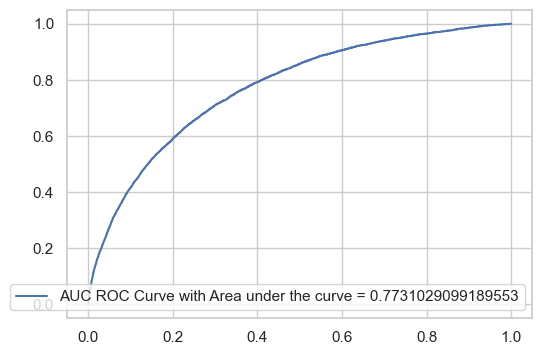

In [49]:
generate_auc_roc_curve(model, X_test)

In [50]:
index += ['XGBoost']
scores['Balance_method'].append('None')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 2° XGB - Undersampling

In [51]:
model = Pipeline(steps = [['under', RandomUnderSampler()],\
                          ['classifier', XGBClassifier(objective='binary:logistic', eval_metric = 'auc')]])

param_grid = { 'classifier__n_estimators' : [100], 'classifier__max_depth' : [3, 5] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7691174064193383
meilleur paramètre :  {'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [52]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,17184,1476
1.0,8493,740


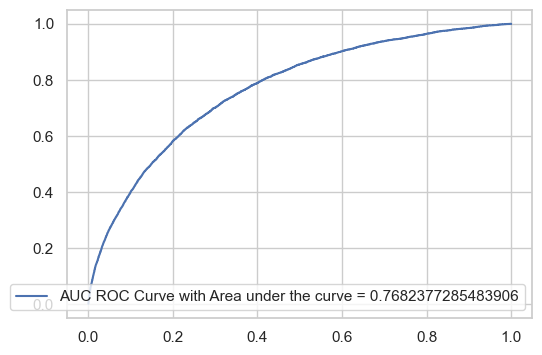

In [53]:
generate_auc_roc_curve(model, X_test)

In [54]:
index += ['XGBoost']
scores['Balance_method'].append('Undersampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 3° XGB - Oversampling

In [55]:
model = Pipeline(steps = [['smote', SMOTE(random_state=11)],\
                          ['classifier', XGBClassifier(objective='binary:logistic', eval_metric = 'auc')]])

# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations XGBoost précédentes
param_grid = { 'classifier__n_estimators' : [100], 'classifier__max_depth' : [3] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7634098119411161
meilleur paramètre :  {'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [56]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25550,2205
1.0,127,11


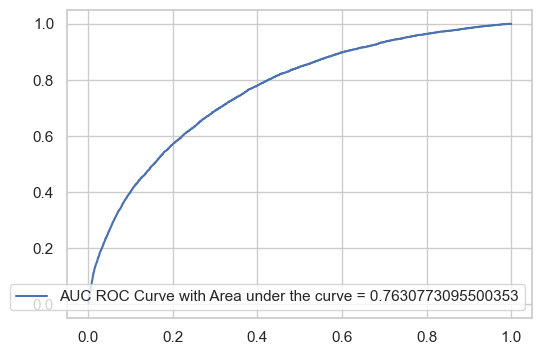

In [57]:
generate_auc_roc_curve(model, X_test)

In [58]:
index += ['XGBoost']
scores['Balance_method'].append('Oversampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 4° XGB - Class_weight = Balanced

In [59]:
Y_train['TARGET'].value_counts()

0.0    197835
1.0     17419
Name: TARGET, dtype: int64

In [60]:
# scale_pos_weight= sum(negative instances) / sum(positive instances)

spw = 197835/17419
spw

11.357425799414433

In [61]:
# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations XGBoost précédentes
param_grid = { "n_estimators" : [100], "max_depth" : [3]}  # maximum depth of the tree                

grid = GS(XGBClassifier(objective='binary:logistic', eval_metric = 'auc', scale_pos_weight = spw),\
          param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7726829521362563
meilleur paramètre :  {'max_depth': 3, 'n_estimators': 100}


In [62]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,17621,1516
1.0,8056,700


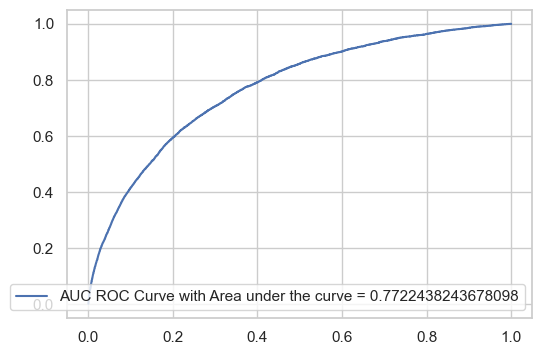

In [63]:
generate_auc_roc_curve(model, X_test)

In [64]:
index += ['XGBoost']
scores['Balance_method'].append('Class_weight=balanced')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


### e) LightGBM - LGBMClassifier

#### 1° LGBMC - Données Brutes

In [65]:
param_grid = { "n_estimators" : [500], # number of trees in the forest
                "max_depth" : [3, 5] }  # maximum depth of the tree

grid = GS(LGBMClassifier(), param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7795089088334892
meilleur paramètre :  {'max_depth': 3, 'n_estimators': 500}


In [66]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25533,2199
1.0,144,17


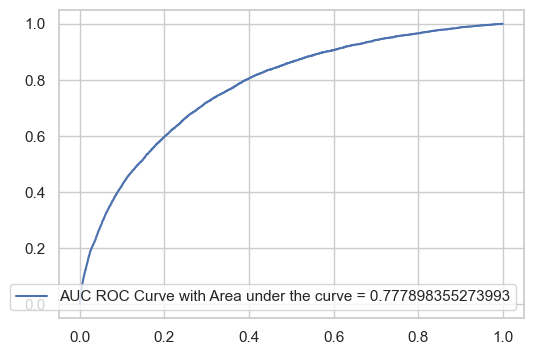

In [67]:
generate_auc_roc_curve(model, X_test)

In [68]:
index += ['LGBMC']
scores['Balance_method'].append('None')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 2° LGBMC - Undersampling

In [69]:
model = Pipeline(steps = [['under', RandomUnderSampler()], ['classifier', LGBMClassifier()]])

param_grid = { 'classifier__n_estimators' : [500], 'classifier__max_depth' : [3, 5] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7740087776363925
meilleur paramètre :  {'classifier__max_depth': 3, 'classifier__n_estimators': 500}


In [70]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,17298,1475
1.0,8379,741


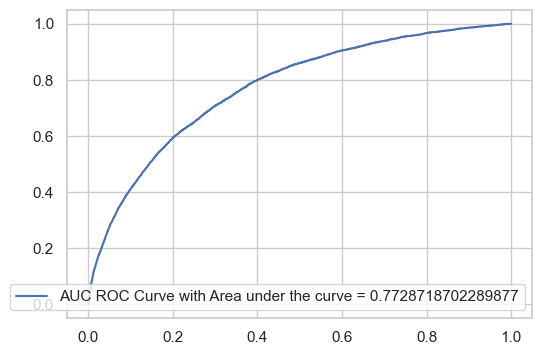

In [71]:
generate_auc_roc_curve(model, X_test)

In [72]:
index += ['LGBMC']
scores['Balance_method'].append('Undersampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 3° LGBMC - Oversampling

In [73]:
model = Pipeline(steps = [['smote', SMOTE(random_state=11)], ['classifier', LGBMClassifier()]])

# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations XGBoost précédentes
param_grid = { 'classifier__n_estimators' : [500], 'classifier__max_depth' : [3] }   
grid = GS(estimator = model, param_grid=param_grid, scoring='roc_auc', cv = 5, n_jobs=-1)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.7744241444684201
meilleur paramètre :  {'classifier__max_depth': 3, 'classifier__n_estimators': 500}


In [74]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,25537,2198
1.0,140,18


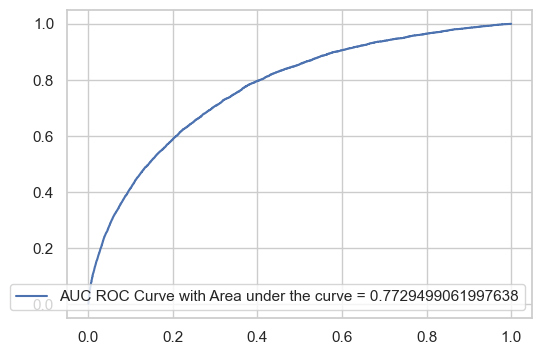

In [75]:
generate_auc_roc_curve(model, X_test)

In [76]:
index += ['LGBMC']
scores['Balance_method'].append('Oversampling')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0


#### 4° LGBMC - Class_weight = Balanced

In [77]:
Y_train['TARGET'].value_counts()

0.0    197835
1.0     17419
Name: TARGET, dtype: int64

In [78]:
# scale_pos_weight= sum(negative instances) / sum(positive instances)

spw = 197835/17419
spw

11.357425799414433

In [79]:
# réutilisation des meilleurs paramètres obtenus avec les 2 modélisations XGBoost précédentes
param_grid = { "n_estimators" : [500], "max_depth" : [3]}  # maximum depth of the tree                

grid = GS(LGBMClassifier(scale_pos_weight = spw),  param_grid, scoring='roc_auc', cv = 5)

#grid = GS(XGBClassifier(objective='binary:logistic', eval_metric = 'auc', scale_pos_weight = spw),\
          #param_grid, scoring='roc_auc', cv = 5)

# Entraînement
grid.fit(X_train, Y_train)
print('meilleur score : ' , grid.best_score_)
print('meilleur paramètre : ' , grid.best_params_)

meilleur score :  0.777665482308602
meilleur paramètre :  {'max_depth': 3, 'n_estimators': 500}


In [80]:
time1 = time.time()

model = grid.best_estimator_
model.fit(X_train, Y_train)

# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

time2 = np.round(time.time() - time1,0)

# Calcul AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_pred_proba)

generate_crosstab()

Actual,0.0,1.0
Predicted,,
0.0,17897,1523
1.0,7780,693


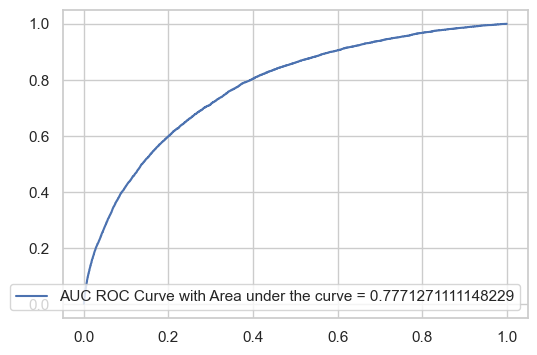

In [81]:
generate_auc_roc_curve(model, X_test)

In [82]:
index += ['LGBMC']
scores['Balance_method'].append('Class_weight=balanced')

scores['AUC'].append(grid.best_score_)
scores['AUC_test'].append(auc.mean()) 
scores['Time'].append(time2) 

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balance_method,AUC,AUC_test,Time
DummyClassifier,None,0.500076,0.500229,0.0
LogisticRegression,None,0.550622,0.550346,22.0
LogisticRegression,Undersampling,0.581259,0.587700,3.0
LogisticRegression,Oversampling,0.587605,0.602902,56.0
LogisticRegression,Class_weight=balanced,0.594089,0.589356,13.0
RandomForest,None,0.733212,0.738083,131.0
RandomForest,Undersampling,0.730992,0.733579,20.0
RandomForest,Oversampling,0.667845,0.662825,365.0
RandomForest,Class_weight=balanced,0.731832,0.734369,116.0
XGBoost,None,0.775080,0.773103,125.0
